In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from properscoring import crps_ensemble
import os
import sys
import calendar

In [4]:
# Add the path to the src directory (two levels up)
sys.path.append(os.path.abspath('../../'))
from src.data_processing import predict_cnbs

In [5]:
# Directory where the repository is cloned
path_to_repo = '/Users/ljob/Desktop/'

# Path to data directory
dir = path_to_repo + 'cnbs-predictor-1/data/'

## Read in PCP data from CFS [Kg]
pcp_data = pd.read_csv(dir+'cfs/CFS_APCP_Basin_Sums_archived.csv',sep=',')

## Read in EVAP data from CFS [Kg]
evap_data = pd.read_csv(dir+'cfs/CFS_EVAP_Basin_Sums_archived.csv',sep=',')

## Read in TMP data from CFS [K]
tmp_data = pd.read_csv(dir + 'cfs/CFS_TMP_Basin_Avgs_archived.csv', sep=',')

In [6]:
# Path to saved scalers
x_scaler = dir + 'input/x_scaler.joblib'
y_scaler = dir + 'input/y_scaler.joblib'

# Define directory to models to use along with their paths
models_info = [{'model': 'GP', 'path': dir + 'input/GP_trained_model.joblib'},
               {'model': 'RF', 'path': dir + 'input/RF_trained_model.joblib'},
               {'model': 'LR', 'path': dir + 'input/LR_trained_model.joblib'},
               {'model': 'NN', 'path': dir + 'input/NN_trained_model.joblib'}]

# Surface area [m2] for each region based on the mask file
lake_areas = {
    'erie': 18596386416.712486, 
    'ontario': 15569248531.837788, 
    'michigan-huron': 123626283030.46616, 
    'superior': 78288645587.81192
    }
land_areas = {
    'erie': 81902183517.35063,
    'ontario': 64465190376.66068,
    'michigan-huron': 236478938454.17358,
    'superior': 123736048741.43369}

In [7]:
def format_observed_data(df):
    # Melt the observed data to long format and create the 'year_month' column in a single step
    observed_df = df.melt(id_vars=['Year'], var_name='Month', value_name='Observed')

    # Combine 'Year' and 'Month' into a proper 'year_month' format and convert to datetime in one step
    observed_df['year_month'] = (pd.to_datetime(observed_df['Year'].astype(str) + '-' + observed_df['Month'].str[1:4], format='%Y-%b')).dt.strftime('%Y-%m')
    # Convert year_month to datetime
    observed_df['year_month'] = pd.to_datetime(observed_df['year_month'])

    # Sort by 'year_month' for proper chronological order
    observed_df = observed_df.sort_values(by='year_month')
    observed_df = observed_df[['year_month', 'Observed']].reset_index(drop=True)

    observed_df.replace(-99990.0, np.nan, inplace=True)
    observed_df = observed_df.dropna()

    return observed_df

In [8]:
# Construct year_month from year and month
X = pd.DataFrame({
    'year_month': pd.to_datetime(pcp_data['year'].astype(str) + '-' + pcp_data['month'].astype(str)).dt.strftime('%Y-%m'),
    
    # Precipitation over lakes
    'superior_lake_precipitation': pcp_data['WaterSuperior'] / lake_areas['superior'],
    'erie_lake_precipitation': pcp_data['WaterErie'] / lake_areas['erie'],
    'ontario_lake_precipitation': pcp_data['WaterOntario'] / lake_areas['ontario'],
    'michigan-huron_lake_precipitation': (pcp_data['WaterMichigan'] + pcp_data['WaterHuron']) / lake_areas['michigan-huron'],

    # Precipitation over land
    'superior_land_precipitation': pcp_data['LandSuperior'] / land_areas['superior'],
    'erie_land_precipitation': pcp_data['LandErie'] / land_areas['erie'],
    'ontario_land_precipitation': pcp_data['LandOntario'] / land_areas['ontario'],
    'michigan-huron_land_precipitation': (pcp_data['LandMichigan'] + pcp_data['LandHuron']) / land_areas['michigan-huron'],

    # Evaporation over lakes
    'superior_lake_evaporation': evap_data['WaterSuperior'] / lake_areas['superior'],
    'erie_lake_evaporation': evap_data['WaterErie'] / lake_areas['erie'],
    'ontario_lake_evaporation': evap_data['WaterOntario'] / lake_areas['ontario'],
    'michigan-huron_lake_evaporation': (evap_data['WaterMichigan'] + evap_data['WaterHuron']) / lake_areas['michigan-huron'],

    # Evaporation over land
    'superior_land_evaporation': evap_data['LandSuperior'] / land_areas['superior'],
    'erie_land_evaporation': evap_data['LandErie'] / land_areas['erie'],
    'ontario_land_evaporation': evap_data['LandOntario'] / land_areas['ontario'],
    'michigan-huron_land_evaporation': (evap_data['LandMichigan'] + evap_data['LandHuron']) / land_areas['michigan-huron'],

    # 2m Air Temperature over lakes
    'superior_lake_air_temperature': tmp_data['WaterSuperior'],
    'erie_lake_air_temperature': tmp_data['WaterErie'],
    'ontario_lake_air_temperature': tmp_data['WaterOntario'],
    'michigan-huron_lake_air_temperature': (tmp_data['WaterMichigan']+tmp_data['WaterHuron']) / 2,

    # 2m Air Temperature over land
    'superior_land_air_temperature': tmp_data['LandSuperior'],
    'erie_land_air_temperature': tmp_data['LandErie'],
    'ontario_land_air_temperature': tmp_data['LandOntario'],
    'michigan-huron_land_air_temperature': (tmp_data['LandMichigan']+tmp_data['LandHuron']) / 2
})

X.set_index(['year_month'], inplace=True)

In [9]:
# Initialize an empty dataframe to store predictions by model name
model_predictions = []

# Process each model and add to DB
for model_info in models_info:
    model_name = model_info['model']
    df_y = predict_cnbs(X, x_scaler, y_scaler, models_info, model_name)
    if df_y is not None:
        # Store the predictions in the dataframe
        df_y['model'] = model_name
        model_predictions.append(df_y)

df = pd.concat(model_predictions, ignore_index=False).reset_index()

4682/4682 ━━━━━━━━━━━━━━━━━━━━ 1s 176us/step


In [10]:
# Calculate NBS using the components
df['superior_cnbs'] = df['superior_precipitation'] - df['superior_evaporation'] + df['superior_runoff']
df['erie_cnbs'] = df['erie_precipitation'] - df['erie_evaporation'] + df['erie_runoff']
df['ontario_cnbs'] = df['ontario_precipitation'] - df['ontario_evaporation'] + df['ontario_runoff']
df['michigan-huron_cnbs'] = df['michigan-huron_precipitation'] - df['michigan-huron_evaporation'] + df['michigan-huron_runoff']

In [11]:
# Save to a CSV [mm]
df.to_csv('CNBS_forecast_archived.csv', sep='\t', index=False)

In [12]:
# Take the median forecast for each forecast month and model
median_df = df.groupby(['model', 'year_month']).median(numeric_only=True).reset_index()

In [13]:
# Open L2 data 
sup_evap = pd.read_csv(dir + 'l2swbm/superiorEvap_MonthlyRun.csv')
sup_runoff = pd.read_csv(dir + 'l2swbm/superiorRunoff_MonthlyRun.csv')
sup_precip = pd.read_csv(dir + 'l2swbm/superiorPrecip_MonthlyRun.csv')

eri_evap = pd.read_csv(dir + 'l2swbm/erieEvap_MonthlyRun.csv')
eri_runoff = pd.read_csv(dir + 'l2swbm/erieRunoff_MonthlyRun.csv')
eri_precip = pd.read_csv(dir + 'l2swbm/eriePrecip_MonthlyRun.csv')

ont_evap = pd.read_csv(dir + 'l2swbm/ontarioEvap_MonthlyRun.csv')
ont_runoff = pd.read_csv(dir + 'l2swbm/ontarioRunoff_MonthlyRun.csv')
ont_precip = pd.read_csv(dir + 'l2swbm/ontarioPrecip_MonthlyRun.csv')

mih_evap = pd.read_csv(dir + 'l2swbm/miHuronEvap_MonthlyRun.csv')
mih_runoff = pd.read_csv(dir + 'l2swbm/miHuronRunoff_MonthlyRun.csv')
mih_precip = pd.read_csv(dir + 'l2swbm/miHuronPrecip_MonthlyRun.csv')

In [14]:
l2_obs = pd.DataFrame({
    'year_month': pd.to_datetime(eri_evap['Year'].astype(int).astype(str) + '-' + eri_evap['Month'].astype(int).astype(str), format='%Y-%m').dt.strftime('%Y-%m'),
    'superior_evaporation_obs': sup_evap['Median'],
    'superior_precipitation_obs': sup_precip['Median'],
    'superior_runoff_obs': sup_runoff['Median'],
    'erie_evaporation_obs': eri_evap['Median'],
    'erie_precipitation_obs': eri_precip['Median'],
    'erie_runoff_obs': eri_runoff['Median'],
    'ontario_evaporation_obs': ont_evap['Median'],
    'ontario_precipitation_obs': ont_precip['Median'],
    'ontario_runoff_obs': ont_runoff['Median'],
    'michigan-huron_evaporation_obs': mih_evap['Median'],
    'michigan-huron_precipitation_obs': mih_precip['Median'],
    'michigan-huron_runoff_obs': mih_runoff['Median']
})

In [15]:
# Load the GLCC observed data
observed_sup = pd.read_csv(dir + 'glcc/LakeSuperior_MonthlyNetBasinSupply_1900to2025.csv', skiprows=11)
observed_mih = pd.read_csv(dir + 'glcc/LakeMichiganHuron_MonthlyNetBasinSupply_1900to2025.csv', skiprows=11)
observed_eri = pd.read_csv(dir + 'glcc/LakeErie_MonthlyNetBasinSupply_1900to2025.csv', skiprows=11)
observed_ont = pd.read_csv(dir + 'glcc/LakeOntario_MonthlyNetBasinSupply_1900to2025.csv', skiprows=11)

df_obs_sup = format_observed_data(observed_sup)
df_obs_sup.rename(columns={'Observed': 'superior_cnbs_obs'}, inplace=True)
df_obs_mih = format_observed_data(observed_mih)
df_obs_mih.rename(columns={'Observed': 'michigan-huron_cnbs_obs'}, inplace=True)
df_obs_eri = format_observed_data(observed_eri)
df_obs_eri.rename(columns={'Observed': 'erie_cnbs_obs'}, inplace=True)
df_obs_ont = format_observed_data(observed_ont)
df_obs_ont.rename(columns={'Observed': 'ontario_cnbs_obs'}, inplace=True)

df_obs_merged = pd.merge(df_obs_sup, df_obs_mih, on="year_month", how="outer")
df_obs_merged = pd.merge(df_obs_merged, df_obs_eri, on="year_month", how="outer")
df_obs_merged = pd.merge(df_obs_merged, df_obs_ont, on="year_month", how="outer")

# Calculate number of seconds in each month
df_obs_merged['seconds_in_month'] = df_obs_merged['year_month'].apply(
    lambda x: calendar.monthrange(x.year, x.month)[1] * 24 * 60 * 60
    )
    
# Convert m³/s to mm using lake surface areas
for col in df_obs_merged.columns:
    if col.endswith('_cnbs_obs'):
        lake = col.replace('_cnbs_obs', '')
        area = lake_areas.get(lake)
        if area:
            df_obs_merged[col] = df_obs_merged[col] * df_obs_merged['seconds_in_month'] / area * 1000

# Drop helper column if desired
df_obs_mm = df_obs_merged.drop(columns='seconds_in_month')
df_obs_mm['year_month'] = pd.to_datetime(df_obs_mm['year_month']).dt.strftime('%Y-%m')

In [16]:
df_merged = pd.merge(median_df, l2_obs, on=('year_month'), how='left')
df_combined = pd.merge(df_merged, df_obs_mm, on=('year_month'), how='left')
df_combined = df_combined.dropna()

In [17]:
df_combined_gp = df_combined[df_combined['model'] == 'GP']
df_combined_lr = df_combined[df_combined['model'] == 'LR']
df_combined_rf = df_combined[df_combined['model'] == 'RF']
df_combined_nn = df_combined[df_combined['model'] == 'NN']

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from properscoring import crps_ensemble

def calculate_total_skill(df, variables, model, label):
    obs_cols = [v + '_obs' for v in variables]
    
    df = df[df['model'] == model]

    # Combine and drop NaNs
    valid_rows = df[variables + obs_cols].dropna()
    y_pred = valid_rows[variables].values.flatten()
    y_true = valid_rows[obs_cols].values.flatten()

    # Standardize
    scaler = StandardScaler()
    y_true_std = scaler.fit_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_std = scaler.transform(y_pred.reshape(-1, 1)).flatten()

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true_std, y_pred_std))
    r2 = r2_score(y_true_std, y_pred_std)
    bias = np.mean(y_pred_std - y_true_std)
    variance = np.var(y_pred_std)
    crps = np.mean(crps_ensemble(y_true_std, y_pred_std[:, None]))  # Ensemble shape [n, 1]

    return pd.DataFrame([{
        'group': label,
        'model': model,
        'rmse': round(rmse, 3),
        'r2': round(r2, 3),
        'bias': round(bias, 3),
        'variance': round(variance, 3),
        'crps': round(crps, 3)
    }])

In [19]:
components = ['precipitation', 'evaporation', 'runoff']
lakes = ['erie', 'superior', 'ontario', 'michigan-huron']

# Variable groups
wb_vars = [f'{lake}_{comp}' for lake in lakes for comp in components]
cnbs_vars = [f'{lake}_cnbs' for lake in lakes]

# Calculate total skill
gp_wb_skill = calculate_total_skill(df_combined, wb_vars, 'GP', 'Water Balance Components')
gp_cnbs_skill = calculate_total_skill(df_combined, cnbs_vars, 'GP', 'CNBS')

rf_wb_skill = calculate_total_skill(df_combined, wb_vars, 'RF', 'Water Balance Components')
rf_cnbs_skill = calculate_total_skill(df_combined, cnbs_vars, 'RF', 'CNBS')

lr_wb_skill = calculate_total_skill(df_combined, wb_vars, 'LR', 'Water Balance Components')
lr_cnbs_skill = calculate_total_skill(df_combined, cnbs_vars, 'LR', 'CNBS')

nn_wb_skill = calculate_total_skill(df_combined, wb_vars, 'NN', 'Water Balance Components')
nn_cnbs_skill = calculate_total_skill(df_combined, cnbs_vars, 'NN', 'CNBS')

# Combine results
all_skill = pd.concat([gp_wb_skill, gp_cnbs_skill, rf_wb_skill, rf_cnbs_skill, lr_wb_skill, lr_cnbs_skill, nn_wb_skill, nn_cnbs_skill])
print(all_skill)

                      group model   rmse     r2   bias  variance   crps
0  Water Balance Components    GP  0.867  0.248 -0.407     0.359  0.661
0                      CNBS    GP  0.911  0.170 -0.286     0.098  0.640
0  Water Balance Components    RF  0.863  0.255 -0.260     0.526  0.639
0                      CNBS    RF  0.879  0.228 -0.111     0.161  0.636
0  Water Balance Components    LR  0.954  0.090 -0.223     0.823  0.771
0                      CNBS    LR  0.923  0.148 -0.316     0.232  0.648
0  Water Balance Components    NN  0.896  0.198 -0.389     0.587  0.686
0                      CNBS    NN  0.876  0.233 -0.193     0.147  0.617


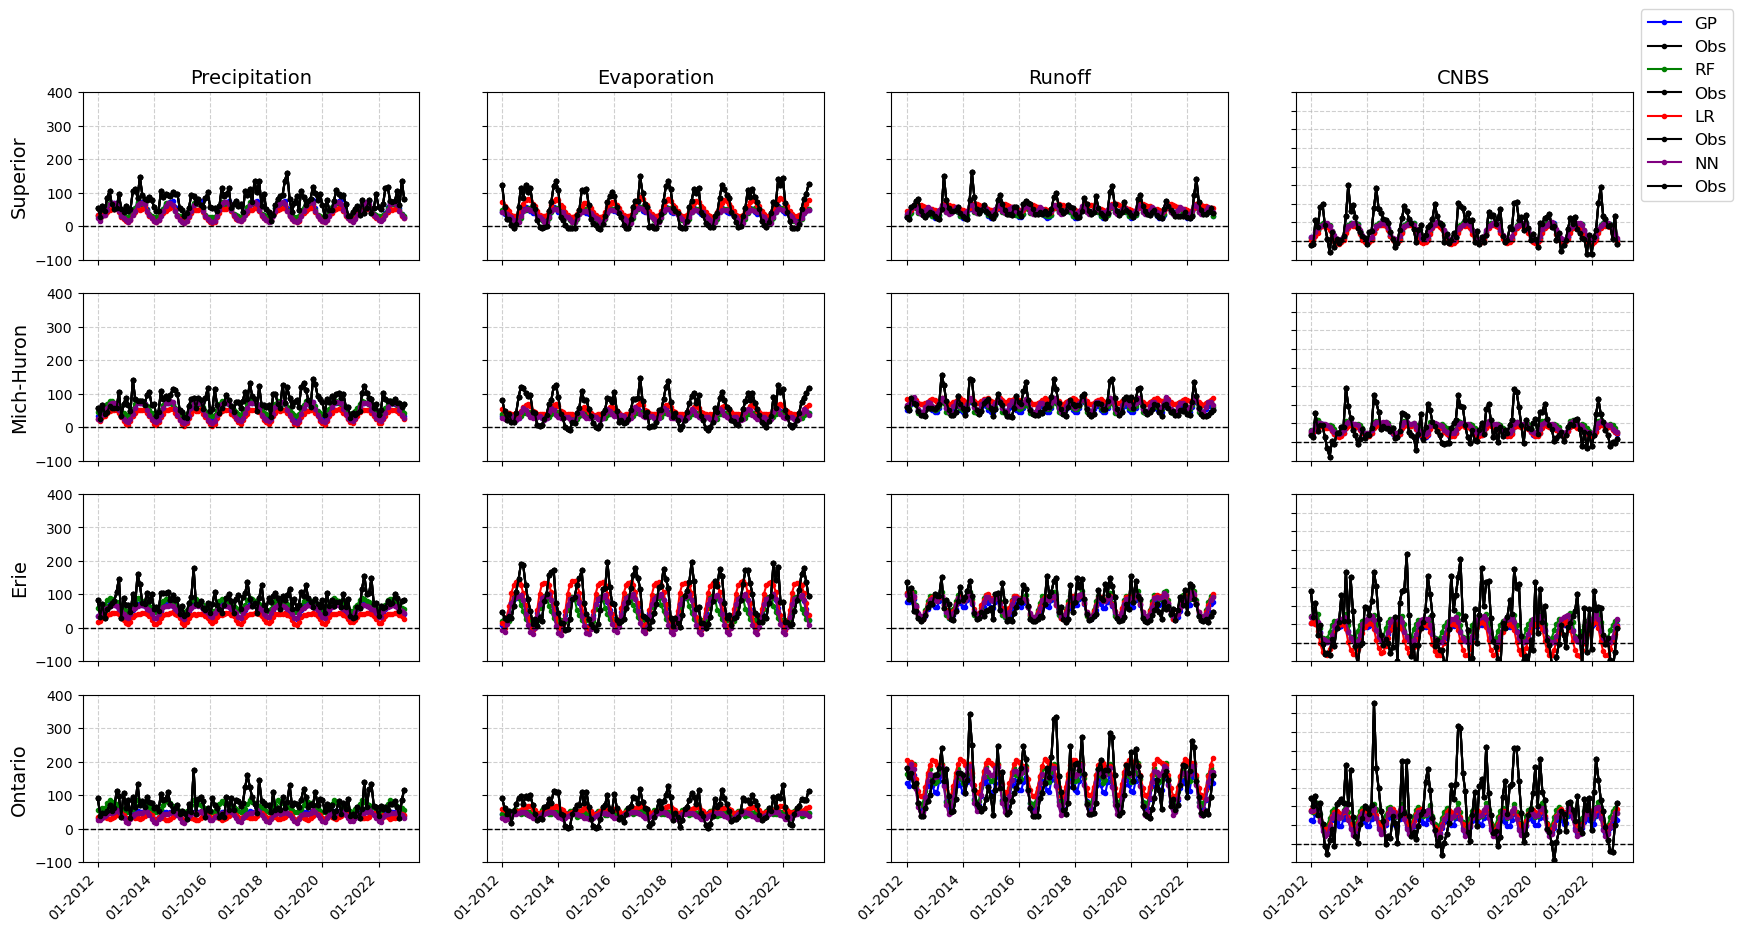

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Define model colors
model_colors = {'GP': 'blue', 'RF': 'green', 'LR': 'red', 'NN': 'purple'}

# Define lake names and components
lakes = ['superior', 'michigan-huron', 'erie', 'ontario']
components = ['precipitation', 'evaporation', 'runoff', 'cnbs']
titles = ['Precipitation', 'Evaporation', 'Runoff', 'CNBS']
ylabels = ['Superior', 'Mich-Huron', 'Erie', 'Ontario']

# Create subplot grid
fig, axs = plt.subplots(4, 4, figsize=(20, 10))
axs = axs.reshape(4, 4)

# Loop through all combinations of lake and component
for row, lake in enumerate(lakes):
    for col, comp in enumerate(components):
        ax = axs[row, col]
        column = f'{lake}_{comp}'
        obs_column = f'{column}_obs'

        for model_info in models_info:
            model_name = model_info['model']
            model_df = df_combined[df_combined['model'] == model_name].copy()
            model_df['date'] = pd.to_datetime(model_df['year_month'])

            # Plot model prediction
            ax.plot(model_df['date'], model_df[column], marker='o', markersize=3,
                    color=model_colors[model_name], label=model_name)

            # Plot observations
            ax.plot(model_df['date'], model_df[obs_column], marker='o', markersize=3,
                    color='black', linewidth=1.5, label='Obs')

        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_yticks(np.arange(-1000, 1000, 100))

        # Set titles and labels
        if row == 0:
            ax.set_title(titles[col], fontsize=14)
        if row == 3:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
            ax.tick_params(axis='x', rotation=45)
            for label in ax.get_xticklabels():
                label.set_horizontalalignment('right')
        else:
            ax.set_xticklabels([])

        if col == 0:
            ax.set_ylabel(ylabels[row], fontsize=14)
        else:
            ax.set_yticklabels([])
        if col == 3:
            ax.set_ylim(-100, 800)
        else:
            ax.set_ylim(-100, 400)

# Add legend once
axs[0, 3].legend(loc='lower left', bbox_to_anchor=(1, 0.3), fontsize=12)

start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2015-01-01')

#for ax_row in axs:
#    for ax in ax_row:
#        ax.set_xlim(start_date, end_date)

# Save and show plot
#plt.tight_layout()
plt.savefig('CNBS_forecasts.png', dpi=300)
plt.show()


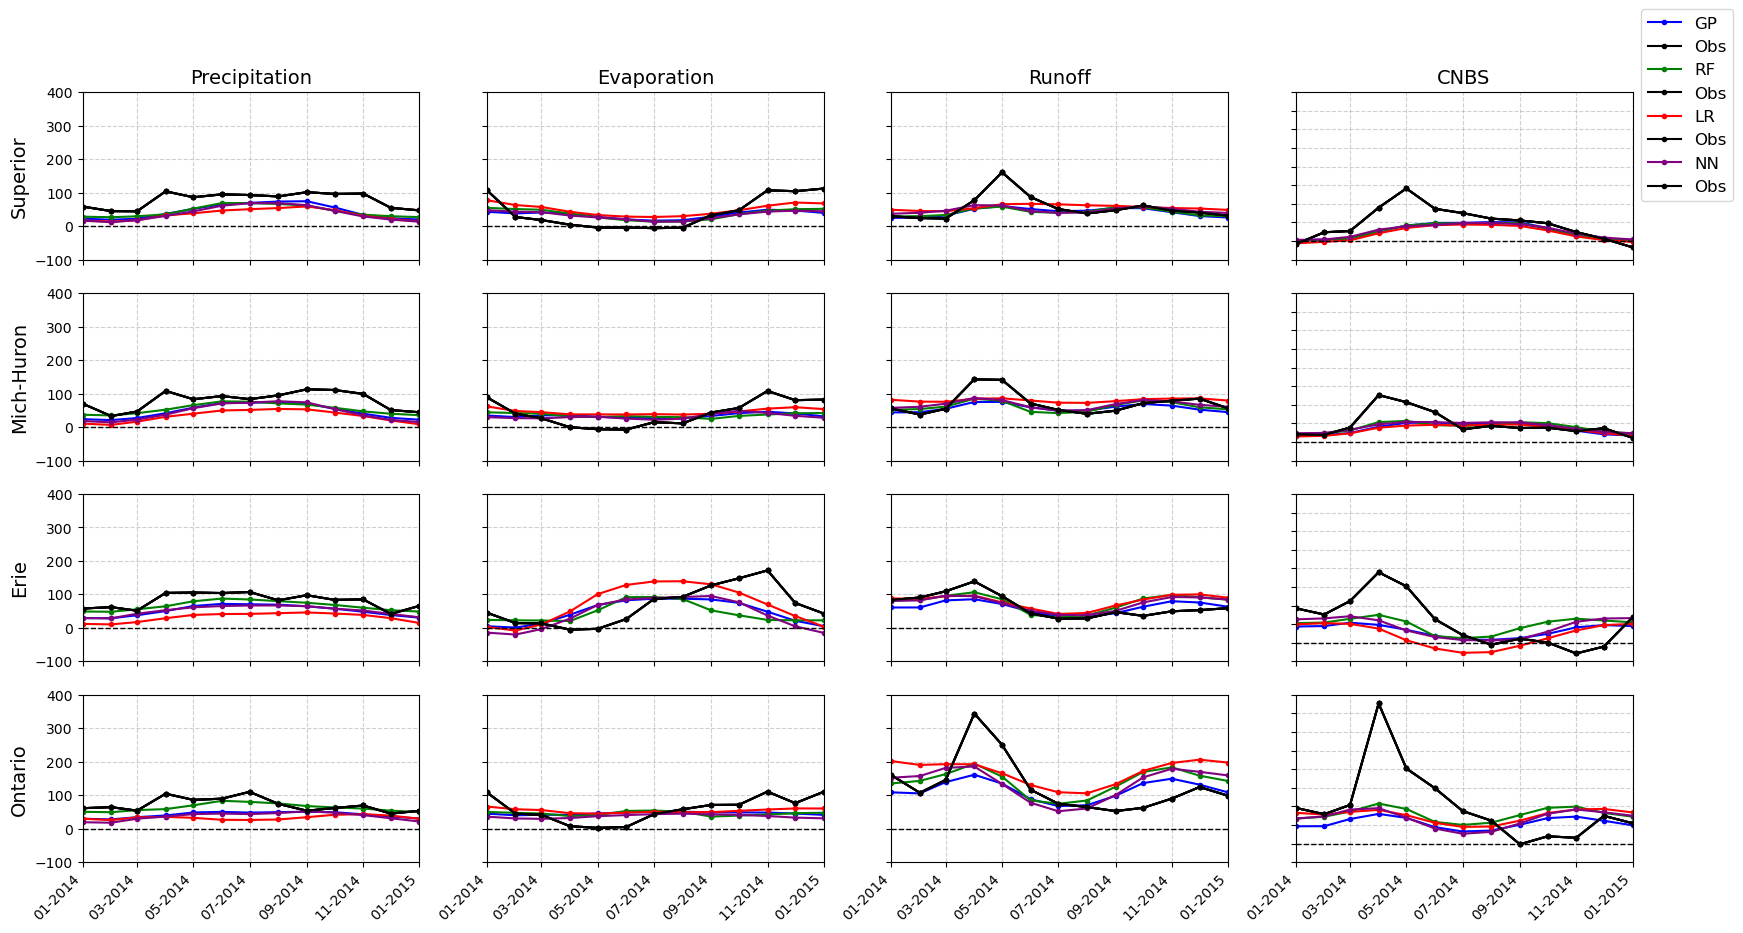

In [35]:
# Define model colors
model_colors = {'GP': 'blue', 'RF': 'green', 'LR': 'red', 'NN': 'purple'}

# Define lake names and components
lakes = ['superior', 'michigan-huron', 'erie', 'ontario']
components = ['precipitation', 'evaporation', 'runoff', 'cnbs']
titles = ['Precipitation', 'Evaporation', 'Runoff', 'CNBS']
ylabels = ['Superior', 'Mich-Huron', 'Erie', 'Ontario']

# Create subplot grid
fig, axs = plt.subplots(4, 4, figsize=(20, 10))
axs = axs.reshape(4, 4)

# Loop through all combinations of lake and component
for row, lake in enumerate(lakes):
    for col, comp in enumerate(components):
        ax = axs[row, col]
        column = f'{lake}_{comp}'
        obs_column = f'{column}_obs'

        for model_info in models_info:
            model_name = model_info['model']
            model_df = df_combined[df_combined['model'] == model_name].copy()
            model_df['date'] = pd.to_datetime(model_df['year_month'])

            # Plot model prediction
            ax.plot(model_df['date'], model_df[column], marker='o', markersize=3,
                    color=model_colors[model_name], label=model_name)

            # Plot observations
            ax.plot(model_df['date'], model_df[obs_column], marker='o', markersize=3,
                    color='black', linewidth=1.5, label='Obs')

        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_yticks(np.arange(-1000, 1000, 100))

        # Set titles and labels
        if row == 0:
            ax.set_title(titles[col], fontsize=14)
        if row == 3:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
            ax.tick_params(axis='x', rotation=45)
            for label in ax.get_xticklabels():
                label.set_horizontalalignment('right')
        else:
            ax.set_xticklabels([])

        if col == 0:
            ax.set_ylabel(ylabels[row], fontsize=14)
        else:
            ax.set_yticklabels([])
        if col == 3:
            ax.set_ylim(-100, 800)
        else:
            ax.set_ylim(-100, 400)

# Add legend once
axs[0, 3].legend(loc='lower left', bbox_to_anchor=(1, 0.3), fontsize=12)

start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2015-01-01')

for ax_row in axs:
    for ax in ax_row:
        ax.set_xlim(start_date, end_date)

# Save and show plot
#plt.tight_layout()
plt.savefig('CNBS_forecasts.png', dpi=300)
plt.show()


In [ ]:
# Compare precipitation and evaporation directly from CFS, model output and observations

# Define model colors
model_colors = {'GP': 'blue', 'RF': 'green', 'LR': 'red', 'NN': 'purple'}

# Define lake names and components
lakes = ['superior', 'michigan-huron', 'erie', 'ontario']
components = ['precipitation', 'evaporation']
titles = ['Precipitation', 'Evaporation',]
ylabels = ['Superior', 'Mich-Huron', 'Erie', 'Ontario']

# Create subplot grid
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.reshape(2, 4)

# Loop through all combinations of lake and component
for row, lake in enumerate(lakes):
    for col, comp in enumerate(components):
        ax = axs[row, col]
        column = f'{lake}_{comp}'
        obs_column = f'{column}_obs'

        for model_info in models_info:
            model_name = model_info['model']
            model_df = df_combined[df_combined['model'] == model_name].copy()
            model_df['date'] = pd.to_datetime(model_df['year_month'])

            # Plot model prediction
            ax.plot(model_df['date'], model_df[column], marker='o', markersize=3,
                    color=model_colors[model_name], label=model_name)

            # Plot observations
            ax.plot(model_df['date'], model_df[obs_column], marker='o', markersize=3,
                    color='black', linewidth=1.5, label='Obs')

        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_yticks(np.arange(-1000, 1000, 100))

        # Set titles and labels
        if row == 0:
            ax.set_title(titles[col], fontsize=14)
        if row == 3:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
            ax.tick_params(axis='x', rotation=45)
            for label in ax.get_xticklabels():
                label.set_horizontalalignment('right')
        else:
            ax.set_xticklabels([])

        if col == 0:
            ax.set_ylabel(ylabels[row], fontsize=14)
        else:
            ax.set_yticklabels([])
        if col == 3:
            ax.set_ylim(-100, 800)
        else:
            ax.set_ylim(-100, 400)

# Add legend once
axs[0, 3].legend(loc='lower left', bbox_to_anchor=(1, 0.3), fontsize=12)

start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2015-01-01')

for ax_row in axs:
    for ax in ax_row:
        ax.set_xlim(start_date, end_date)

# Save and show plot
#plt.tight_layout()
plt.savefig('CNBS_forecasts.png', dpi=300)
plt.show()